In [40]:
import torch
from torchvision import models
import torch.nn as nn
import pandas as pd
import os
import glob
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import higher
import random
from sklearn.model_selection import ParameterGrid
import time
import copy
import torch.nn.functional as F
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import lime
from lime import lime_image
import shap
import numpy as np

# Dataset

In [41]:
spineData : str = "../data/spine"

In [42]:
normalPath : str = "../data/spine/Normal"
osteopenia : str = "../data/spine/Osteopenia"
Osteoporosis : str = "../data/spine/Osteoporosis"

In [43]:
df = pd.DataFrame(columns=["path", "category"])
df

,path,category


In [44]:
def list_images(folder_path):
    extensions = ('*.png', '*.jpg', '*.jpeg', '*.bmp', '*.gif', '*.tiff', '*.webp')

    image_paths = []
    for ext in extensions:
        image_paths.extend(glob.glob(os.path.join(folder_path, ext)))

    return [os.path.abspath(img) for img in image_paths]

In [45]:
def assignCategory(df : pd.DataFrame, images : list[str], category : str) -> pd.DataFrame:
  for image in images:
    new_row = pd.DataFrame([{"path": image, "category": category}])
    df = pd.concat([df, new_row], ignore_index=True)
  return df

In [46]:
df = assignCategory(df, list_images(normalPath), "Normal")
df = assignCategory(df, list_images(osteopenia), "Osteopenia")
df = assignCategory(df, list_images(Osteoporosis), "Osteoporosis")

In [47]:
class Xray(Dataset):
  def __init__(self, df : pd.DataFrame):
    self.df = df
    self.transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    #{0 : normal, 1 : osteia, 2 : osteois}
  def __len__(self):
    return len(self.df)
  def __getitem__(self, idx):
    image_path = self.df.iloc[idx]["path"]
    label = self.df.iloc[idx]["category"]
    if label == "Normal":
      label = torch.tensor(0, dtype=torch.long)
    elif label == "Osteopenia":
      label = torch.tensor(1, dtype=torch.long)
    elif label == "Osteoporosis":
      label = torch.tensor(2, dtype=torch.long)
    else:
      raise ValueError("Invalid label")
    image = Image.open(image_path).convert("RGB")
    image = self.transforms(image)
    return image, label

In [48]:
xrays = Xray(df)

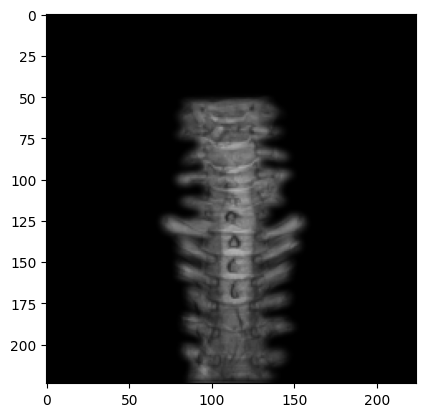

In [49]:
image = xrays[4][0]
image = image.permute(1, 2, 0).numpy()
plt.imshow(image)

In [50]:
train_size = int(0.8 * len(df))
test_size = len(df) - train_size
train_dataset, test_dataset = random_split(xrays, [train_size, test_size])

In [51]:
trainLoader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
testLoader = DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=True)

In [52]:
len(xrays)

136

# Model

In [53]:
# Define the hyperparameter grid to search
param_grid = {
    'learning_rate': [0.01, 0.001, 0.0001],
    'weight_decay': [1e-3, 1e-4, 1e-5],
    'batch_size': [8, 16],
    'dropout_rate': [0.2, 0.5]
}

# Create all combinations of hyperparameters
grid = list(ParameterGrid(param_grid))
print(f"Total number of hyperparameter combinations: {len(grid)}")

Total number of hyperparameter combinations: 36


In [54]:
# Function to modify MobileNet with dropout
def get_mobilenet_with_dropout(dropout_rate=0.0, num_classes=3):
    model = models.mobilenet_v2(weights=None)

    # Add dropout before the final classifier layer
    if dropout_rate > 0:
        model.classifier = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(in_features=1280, out_features=num_classes)
        )
    else:
        model.classifier[1] = nn.Linear(in_features=1280, out_features=num_classes)

    return model

In [55]:
# Function to train and evaluate with specific hyperparameters
def train_and_evaluate(params, train_dataset, test_dataset, device, num_epochs=100):
    # Create data loaders with the specified batch size
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=params['batch_size'], shuffle=False, drop_last=True)

    # Initialize model with dropout
    model = get_mobilenet_with_dropout(dropout_rate=params['dropout_rate'], num_classes=3)
    model = model.to(device)

    # Initialize optimizer with the specified learning rate and weight decay
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])
    criterion = nn.CrossEntropyLoss()

    best_test_f1 = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    history = {
        'train_loss': [], 'train_acc': [], 'train_f1': [],
        'test_loss': [], 'test_acc': [], 'test_f1': []
    }

    # Early stopping parameters
    patience = 5
    early_stop_counter = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss, all_preds, all_labels = 0.0, [], []

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        train_loss = running_loss / len(train_loader)
        train_acc = accuracy_score(all_labels, all_preds)
        train_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['train_f1'].append(train_f1)

        # Testing phase
        model.eval()
        running_loss, all_preds, all_labels = 0.0, [], []

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        test_loss = running_loss / len(test_loader)
        test_acc = accuracy_score(all_labels, all_preds)
        test_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)
        history['test_f1'].append(test_f1)

        # Save best model based on test F1 score
        if test_f1 > best_test_f1:
            best_test_f1 = test_f1
            best_model_wts = copy.deepcopy(model.state_dict())
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        # Print progress every few epochs
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] - "
                  f"Train Loss: {train_loss:.4f}, F1: {train_f1:.4f} | "
                  f"Test Loss: {test_loss:.4f}, F1: {test_f1:.4f}")

        # Early stopping
        if early_stop_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    # Load best model weights
    model.load_state_dict(best_model_wts)

    # Final evaluation on test set
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    final_acc = accuracy_score(all_labels, all_preds)
    final_prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    final_rec = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    final_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    results = {
        'accuracy': final_acc,
        'precision': final_prec,
        'recall': final_rec,
        'f1': final_f1,
        'history': history,
        'model': model,
        'best_epoch': epoch + 1 - early_stop_counter
    }

    return results

In [56]:
# Main grid search loop
def grid_search(train_dataset, test_dataset, device):
    results = []
    start_time = time.time()

    for i, params in enumerate(grid):
        print(f"\nTesting hyperparameter set {i+1}/{len(grid)}")
        print(f"Parameters: {params}")

        # Train and evaluate the model with the current hyperparameters
        try:
            result = train_and_evaluate(params, train_dataset, test_dataset, device)
            result['params'] = params
            results.append(result)

            print(f"Completed hyperparameter set {i+1}/{len(grid)}")
            print(f"Test accuracy: {result['accuracy']:.4f}, F1: {result['f1']:.4f}")
        except Exception as e:
            print(f"Error with parameters {params}: {e}")

    # Find the best hyperparameters based on test F1 score
    results.sort(key=lambda x: x['f1'], reverse=True)
    best_result = results[0]

    total_time = time.time() - start_time
    print(f"\nGrid search completed in {total_time/60:.2f} minutes")
    print(f"Best hyperparameters: {best_result['params']}")
    print(f"Best test F1 score: {best_result['f1']:.4f}")
    print(f"Best test accuracy: {best_result['accuracy']:.4f}")

    return results, best_result

In [57]:
# Run grid search
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Run grid search
results, best_result = grid_search(train_dataset, test_dataset, device)

Using device: cuda

Testing hyperparameter set 1/36
Parameters: {'batch_size': 8, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'weight_decay': 0.001}
Epoch [1/100] - Train Loss: 1.8246, F1: 0.3716 | Test Loss: 1.6815, F1: 0.1505
Epoch [5/100] - Train Loss: 1.1203, F1: 0.3389 | Test Loss: 1.1444, F1: 0.1505
Early stopping at epoch 6
Completed hyperparameter set 1/36
Test accuracy: 0.2917, F1: 0.1505

Testing hyperparameter set 2/36
Parameters: {'batch_size': 8, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'weight_decay': 0.0001}
Epoch [1/100] - Train Loss: 2.2084, F1: 0.3880 | Test Loss: 1.5230, F1: 0.1505
Epoch [5/100] - Train Loss: 1.3406, F1: 0.3685 | Test Loss: 1.2771, F1: 0.1505
Early stopping at epoch 6
Completed hyperparameter set 2/36
Test accuracy: 0.2917, F1: 0.1505

Testing hyperparameter set 3/36
Parameters: {'batch_size': 8, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'weight_decay': 1e-05}
Epoch [1/100] - Train Loss: 2.0273, F1: 0.3481 | Test Loss: 2.8483, F1: 0.1505
Epoch [

In [58]:
best_result

{'accuracy': 0.6666666666666666,
 'precision': 0.6904761904761906,
 'recall': 0.6761904761904761,
 'f1': 0.6694677871148459,
 'history': {'train_loss': [1.0725438044621394,
   0.9866604804992676,
   0.9859550732832688,
   0.9092850089073181,
   0.8807529119344858,
   0.840911287527818,
   0.7370954751968384,
   0.640535077223411,
   0.5459939218484439,
   0.39683467837480396,
   0.3541426440844169,
   0.36227359680029064,
   0.296563330751199,
   0.24276053790862745,
   0.29750580111375224,
   0.33145031791466933,
   0.25552371631448084,
   0.3437522053718567,
   0.2727370835267581,
   0.18659003021625373,
   0.26330590577652824,
   0.1735621215059207,
   0.14084819718622243,
   0.09825430180017765,
   0.15713927837518546,
   0.19597121729300573,
   0.16757703923548645,
   0.12580994960780328,
   0.11181826889514923,
   0.2475985950575425,
   0.08690194319933653,
   0.21092338645114347,
   0.08704459101248246,
   0.16119438932778743],
  'train_acc': [0.47115384615384615,
   0.5,
   0.5

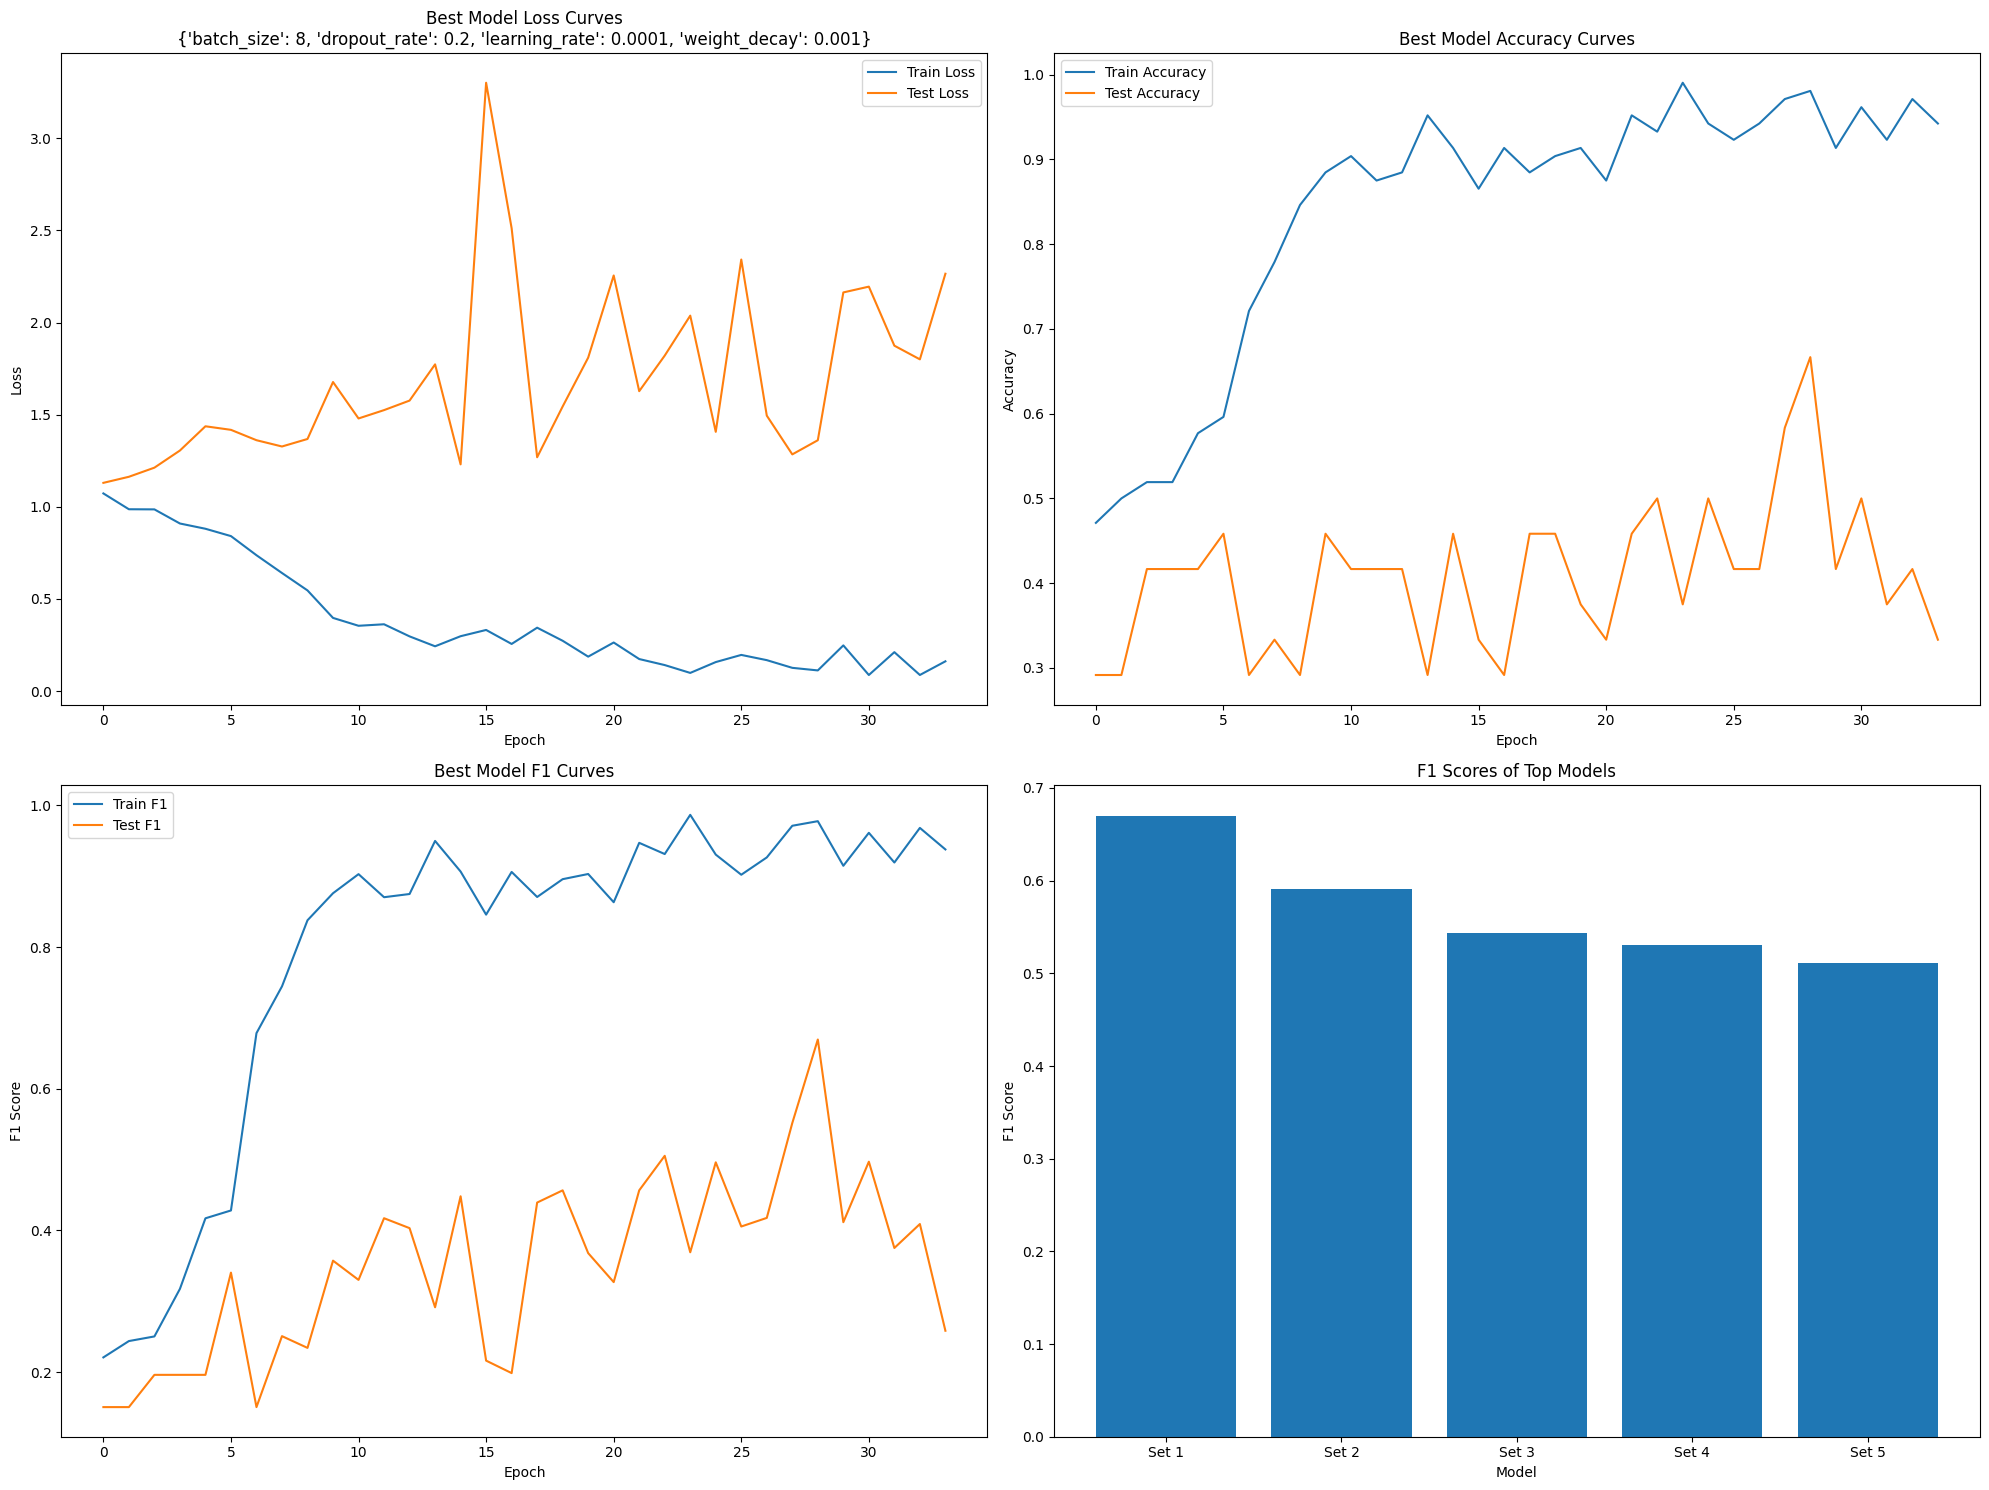

In [59]:
# Visualize results for top performers
top_n = 5  # Number of top performers to plot
top_results = results[:top_n]

# Create figure for learning curves
plt.figure(figsize=(20, 15))

# Plot learning curves for the best model
best_history = best_result['history']
best_params = best_result['params']

plt.subplot(2, 2, 1)
plt.plot(best_history['train_loss'], label='Train Loss')
plt.plot(best_history['test_loss'], label='Test Loss')
plt.title(f'Best Model Loss Curves\n{best_params}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(best_history['train_acc'], label='Train Accuracy')
plt.plot(best_history['test_acc'], label='Test Accuracy')
plt.title('Best Model Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(best_history['train_f1'], label='Train F1')
plt.plot(best_history['test_f1'], label='Test F1')
plt.title('Best Model F1 Curves')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

# Plot bar chart of F1 scores for top models
plt.subplot(2, 2, 4)
labels = [f"Set {i+1}" for i in range(top_n)]
f1_scores = [result['f1'] for result in top_results]
plt.bar(labels, f1_scores)
plt.title('F1 Scores of Top Models')
plt.xlabel('Model')
plt.ylabel('F1 Score')

plt.tight_layout()
plt.savefig('grid_search_results.png')
plt.show()

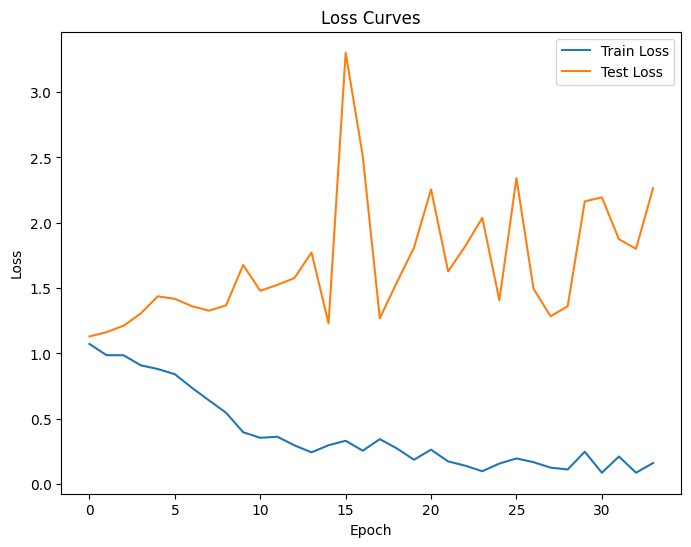

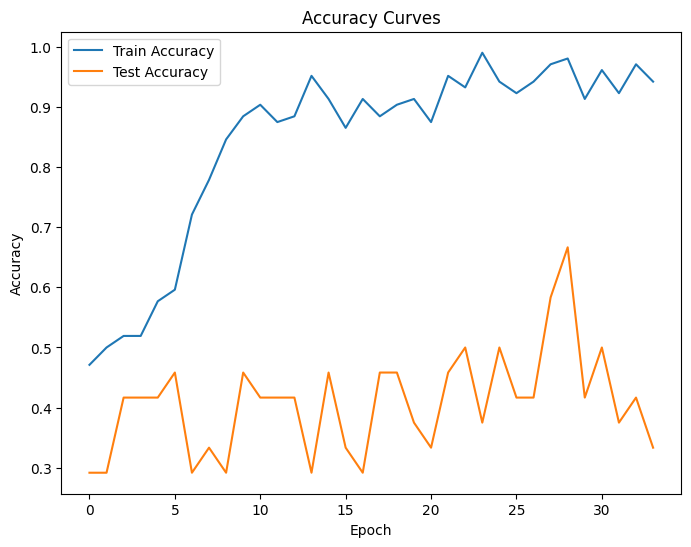

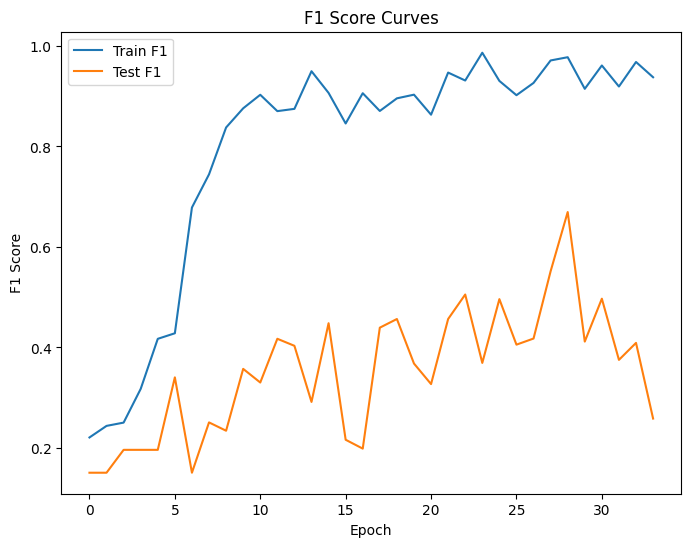

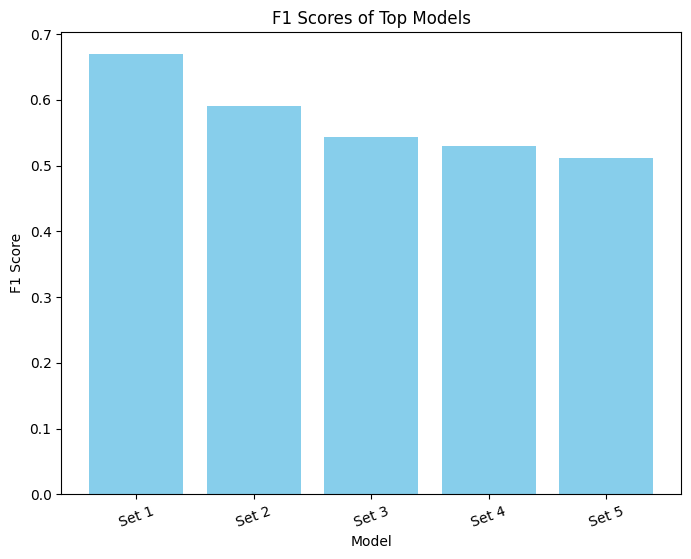

In [60]:
# Loss Curves
plt.figure(figsize=(8, 6))
plt.plot(best_history['train_loss'], label='Train Loss')
plt.plot(best_history['test_loss'], label='Test Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_curves.rl.svg', bbox_inches='tight')
plt.savefig('loss_curves.rl.jpg', bbox_inches='tight')
plt.show()

# Accuracy Curves
plt.figure(figsize=(8, 6))
plt.plot(best_history['train_acc'], label='Train Accuracy')
plt.plot(best_history['test_acc'], label='Test Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy_curves.rl.svg', bbox_inches='tight')
plt.savefig('accuracy_curves.rl.jpg', bbox_inches='tight')
plt.show()

# F1 Score Curves
plt.figure(figsize=(8, 6))
plt.plot(best_history['train_f1'], label='Train F1')
plt.plot(best_history['test_f1'], label='Test F1')
plt.title('F1 Score Curves')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.savefig('f1_curves.rl.svg', bbox_inches='tight')
plt.savefig('f1_curves.rl.jpg', bbox_inches='tight')
plt.show()

# F1 Scores of Top Models (Bar Chart)
plt.figure(figsize=(8, 6))
labels = [f"Set {i+1}" for i in range(top_n)]
f1_scores = [result['f1'] for result in top_results]
plt.bar(labels, f1_scores, color='skyblue')
plt.title('F1 Scores of Top Models')
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.xticks(rotation=20)  # Avoid label overlap
plt.savefig('f1_scores.rl.svg', bbox_inches='tight')
plt.savefig('f1_scores.rl.jpg', bbox_inches='tight')
plt.show()


In [74]:
# Save the best model
torch.save(best_result['model'].state_dict(), 'best_mobilenet_modelv2.pth')

# Create a summary DataFrame of all results
summary_data = []
for result in results:
    summary_dict = {
        **result['params'],
        'accuracy': result['accuracy'],
        'precision': result['precision'],
        'recall': result['recall'],
        'f1': result['f1'],
        'best_epoch': result['best_epoch']
    }
    summary_data.append(summary_dict)

summary_df = pd.DataFrame(summary_data)
summary_df.to_csv('grid_search_summary.csv', index=False)
print("Grid search summary saved to 'grid_search_summary.csv'")

Grid search summary saved to 'grid_search_summary.csv'


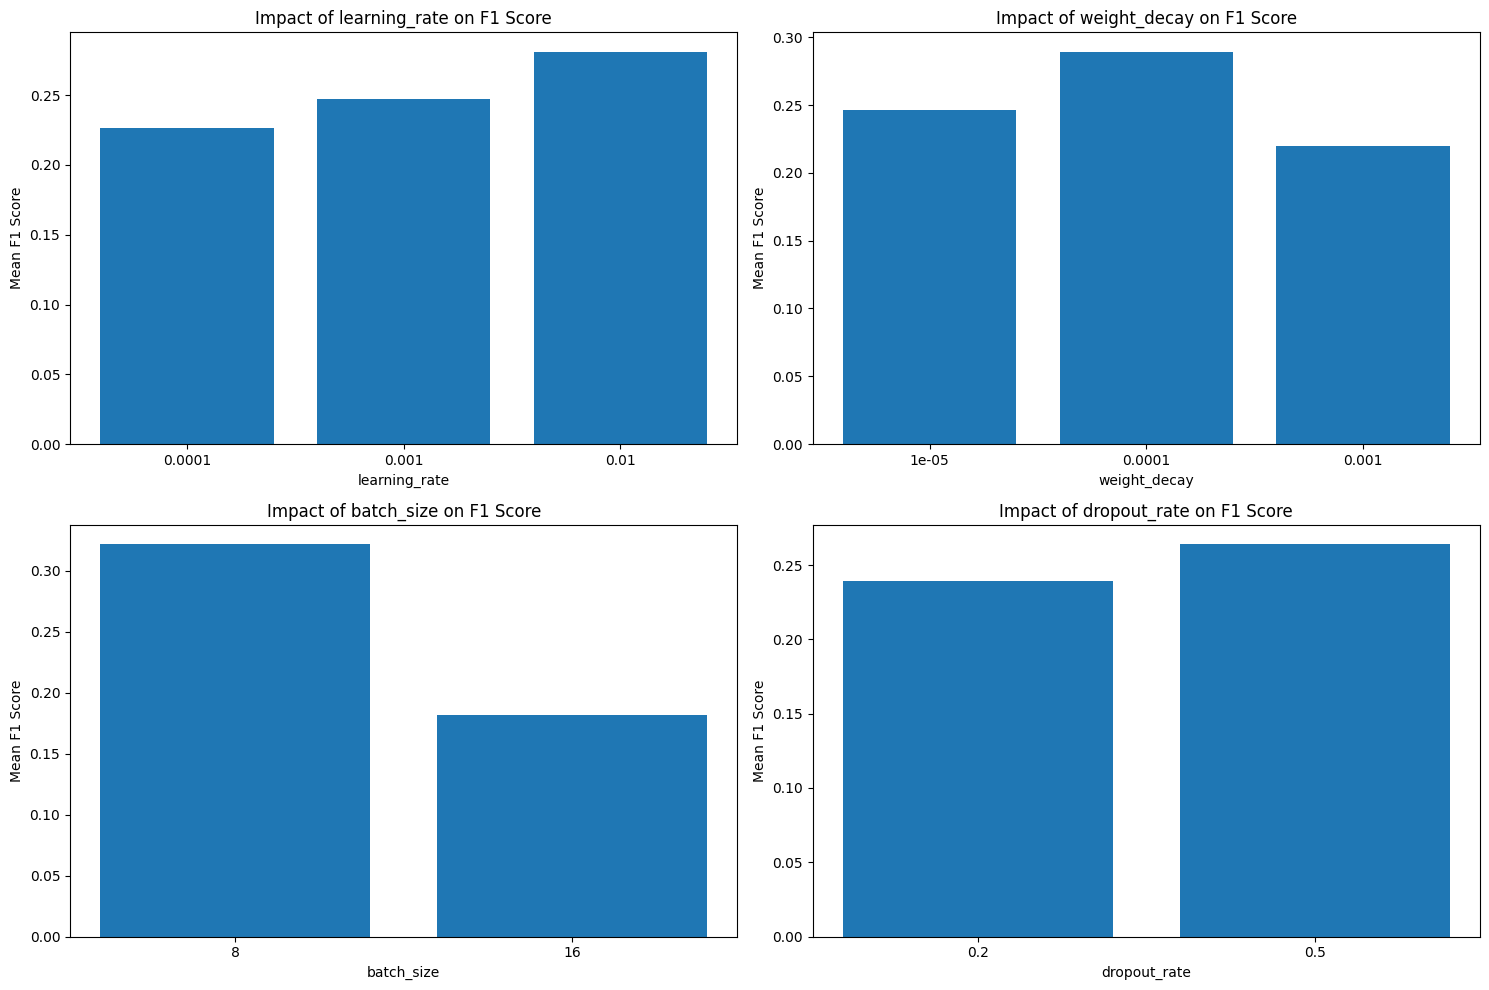

In [75]:
# Analyze which hyperparameters had the most impact
plt.figure(figsize=(15, 10))

# Group results by each hyperparameter
for i, param_name in enumerate(param_grid.keys()):
    plt.subplot(2, 2, i+1)
    param_values = sorted(param_grid[param_name])
    mean_f1_scores = []

    for value in param_values:
        matched_results = [r['f1'] for r in results if r['params'][param_name] == value]
        mean_f1 = np.mean(matched_results) if matched_results else 0
        mean_f1_scores.append(mean_f1)

    plt.bar([str(v) for v in param_values], mean_f1_scores)
    plt.title(f'Impact of {param_name} on F1 Score')
    plt.xlabel(param_name)
    plt.ylabel('Mean F1 Score')

plt.tight_layout()
plt.savefig('hyperparameter_importance.png')
plt.show()